# Supply Curve Temporal Profiles

One major advantage of `reV` supply curve outputs is that they come with temporal capacity factor profiles that can be used for downstream analysis.
In this quick guide, we will demonstrate how to take a supply curve CSV and extract the corresponding temporal profiles form the accompanying HDF5 file.

We will demonstrate how to do this using two methods: Using the custom `rex` library (recommended) or the `h5py` library.

Let's start with a few common imports:

In [42]:
import urllib.request
from pathlib import Path
from multiprocessing.pool import ThreadPool

import pandas as pd
import matplotlib.pyplot as plt

## Downloading the data

Before we dive into the code, we first have to download some supply curve and temporal data from 
[Siting Lab](https://data.openei.org/submissions/6119). This step can take some time, since the temporal HDF5 files are quite large. If you have already downloaded the data, you can skip this step (just make sure path variables below are set correctly).

We'll start by defining the local file path destinations:

In [19]:
# Modify these to point to your local files if you have already downloaded them
PV_SUPPLY_CURVE_FILEPATH = "reference_access_2030_moderate_supply-curve.csv"
WIND_SUPPLY_CURVE_FILEPATH = "reference_access_2030_moderate_115hh_170rd_supply-curve.csv"
PV_CF_FILEPATH = "reference_access_2030_moderate_rep-profiles_2012.h5"
WIND_CF_FILEPATH = "reference_access_2030_moderate_115hh_170rd_rep-profiles_2012.h5"

Next, we can write a short download function using `urllib`,
which is part of the Python standard library.

In [20]:
# Set the web links for each file (you shouldn't have to modify this at all)
URLS = {
    PV_SUPPLY_CURVE_FILEPATH: "https://data.openei.org/files/6001/reference_access_2030_moderate_supply-curve.csv",
    WIND_SUPPLY_CURVE_FILEPATH : "https://data.openei.org/files/6119/reference_access_2030_moderate_115hh_170rd_supply-curve%20(1).csv",
    PV_CF_FILEPATH: "https://data.openei.org/files/6001/reference_access_2030_moderate_rep-profiles_2012.h5",
    WIND_CF_FILEPATH: "https://data.openei.org/files/6119/reference_access_2030_moderate_115hh_170rd_rep-profiles_2012.h5",
}

def download_sc_file(local_filepath):
    if local_filepath not in URLS:
        print(f"Unknown destination file: {str(local_filepath)!r}")
        return

    if Path(local_filepath).exists():
        print(f"{str(local_filepath)!r} already exists!")
        return

    urllib.request.urlretrieve(URLS[local_filepath], local_filepath)
    print(f"Downloaded {str(local_filepath)!r}!")

Now, we can download the files by calling this function on each of our target file destinations:

In [44]:
files_to_download = [
    PV_SUPPLY_CURVE_FILEPATH,
    WIND_SUPPLY_CURVE_FILEPATH,
    PV_CF_FILEPATH,
    WIND_CF_FILEPATH,
]

with ThreadPool(len(files_to_download)) as p:
    p.map(download_sc_file, files_to_download)

'reference_access_2030_moderate_115hh_170rd_rep-profiles_2012.h5' already exists!
'reference_access_2030_moderate_rep-profiles_2012.h5' already exists!
Downloaded 'reference_access_2030_moderate_115hh_170rd_supply-curve.csv'!
Downloaded 'reference_access_2030_moderate_supply-curve.csv'!


## Using [`rex`](https://github.com/NREL/rex/) (recommended)

We recommend using the `rex` (https://github.com/NREL/rex/) library to read temporal profiles. This library was used to write the reV data to file and makes interfacing with these HDF5 file seamless. 

Let's begin by reading in the supply curve CSV using `pandas`:

In [22]:
reference_solar_supply_curve = pd.read_csv(PV_SUPPLY_CURVE_FILEPATH)
reference_solar_supply_curve.head()

,area_sq_km,capacity_mw_ac,capacity_mw_dc,cnty_fips,country,county,dist_km,elevation,latitude,lcot,...,mean_lcoe,mean_res,reg_mult,reinforcement_cost_per_mw_ac,reinforcement_dist_km,sc_point_gid,state,timezone,total_lcoe,trans_cap_cost_per_mw_ac
0,7.712496,247.490549,331.637319,53073,United States,Whatcom,0.996396,23.200000,48.994,38.928281,...,59.853846,3.378569,1.018719,813613.051309,229.418435,416,Washington,-8,98.782127,2.478331e+04
1,4.310253,138.314081,185.340881,53055,United States,San Juan,13.957494,32.833333,49.022,43.380831,...,60.695306,3.322941,1.015777,813267.157762,229.381156,417,Washington,-8,104.076137,1.058802e+05
2,0.524880,16.843166,22.569838,53073,United States,Whatcom,7.467351,20.000000,48.873,134.445588,...,58.353135,3.465000,1.019095,806946.654393,216.319915,795,Washington,-8,192.798723,2.163971e+06
3,19.699603,632.151484,847.082947,53073,United States,Whatcom,138.027487,39.705882,48.900,32.593987,...,58.716111,3.435809,1.018810,155465.852169,54.229805,796,Washington,-8,91.310098,5.601646e+05
4,6.517908,209.156733,280.270041,53073,United States,Whatcom,18.529403,28.588235,48.927,39.755888,...,60.224078,3.355201,1.016223,722181.354190,188.072065,797,Washington,-8,99.979966,1.270589e+05


As we can see, every row of the supply curve has a unique `sc_point_gid` value. This is what we will use to link with the temporal profiles. Let's begin by reading in the metadata from the rep-profiles HDF5 file using the `Resource` class in `rex`:

In [23]:
from rex import Resource

with Resource(PV_CF_FILEPATH) as res:
    print(res.shapes)

print("Supply curve length:", len(reference_solar_supply_curve))

{'meta': (57632,), 'rep_profiles_0': (8760, 57632), 'time_index': (8760,)}
Supply curve length: 57632


As we can see, the HDF5 file contains the profiles in the "rep_profiles_0" dataset. Also, the length of the supply curve matches the spatial shape (second index) of the temporal profiles. This makes it easy to extract the profile for the point of interest: simply find the resource file meta index corresponding to the `sc_point_gid` of the supply curve point you are interested in and extract the profile that index. 


### Extracting info by SC point GID

If you already know what sc point gid(s) you want to examine, extraction is straightforward:

In [24]:
# Determine what gid to examine using the "reference_solar_supply_curve"
sc_point_gid_of_interest = 34256

with Resource(PV_CF_FILEPATH) as res:
    ind = res.meta[
        res.meta["sc_point_gid"] == sc_point_gid_of_interest
    ].index
    profile = res["rep_profiles_0", :, ind]
    ti = res.time_index

profile.shape

(8760, 1)

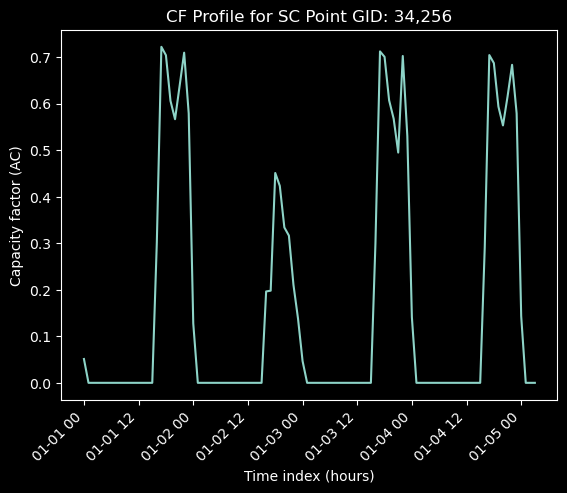

In [25]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {sc_point_gid_of_interest:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

You can also extract multiple profiles at the same time:

In [26]:
sc_point_gids_of_interest = [34256, 23446, 8765, 99877]
points = reference_solar_supply_curve[
    reference_solar_supply_curve["sc_point_gid"].isin(
        sc_point_gids_of_interest
    )
]

with Resource(PV_CF_FILEPATH) as res:
    inds = res.meta[
        res.meta["sc_point_gid"].isin(sc_point_gids_of_interest)
    ].index
    profiles = res["rep_profiles_0", :, inds]
    ti = res.time_index

profiles.shape

(8760, 4)

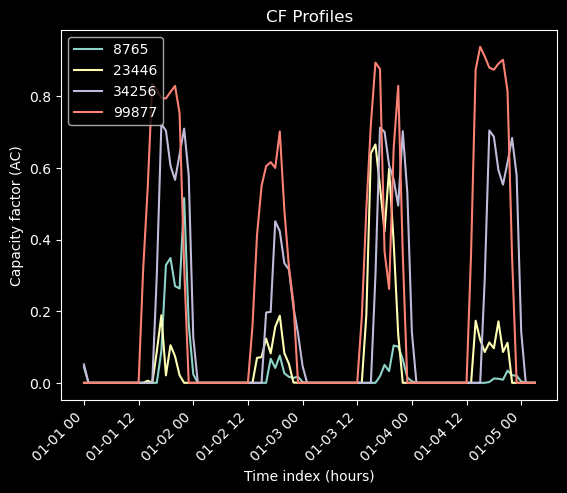

In [27]:
plt.plot(ti[:100], profiles[:100], label=points["sc_point_gid"])
plt.title(f"CF Profiles")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left");

### Extracting info by Lat/Lon

Often you have a location you'd like to examine in particular. You know the lat/lon but don't know which SC point GID they belong to. In this case, you can use `rex.ResourceX` to look up the index!

In [28]:
from rex import ResourceX

with ResourceX(PV_CF_FILEPATH) as res:
    ind = res.lat_lon_gid((48.346832, -124.6527))
    sc_point_gid = int(res.meta.loc[ind, "sc_point_gid"])

ind, sc_point_gid

(16, 1543)

You can then extract the supply curve information:

In [29]:
point = reference_solar_supply_curve[
    reference_solar_supply_curve["sc_point_gid"] == sc_point_gid
]
point[[
    "latitude", "longitude", "capacity_mw_ac", "area_sq_km", "mean_cf_ac",
    "lcot", "total_lcoe"
]]

,latitude,longitude,capacity_mw_ac,area_sq_km,mean_cf_ac,lcot,total_lcoe
16,48.347,-124.653,258.324206,8.050104,0.186349,80.338917,144.342298


and the profile information just like before!

In [30]:
with Resource(PV_CF_FILEPATH) as res:
    profile = res["rep_profiles_0", :, ind]
    ti = res.time_index

profile.shape

(8760,)

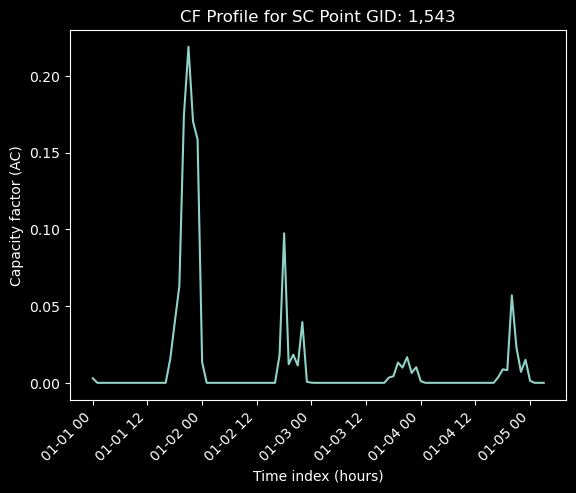

In [31]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {point['sc_point_gid'].iloc[0]:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

## Using `h5py`

You can also use the standard `h5py` library to read the temporal profiles.
The access pattern remains largely the same, except that you have to perform more processing as you load in the data.

Let's begin the example once agin by reading in the supply curve CSV using `pandas` (this time for land-based wind):

In [32]:
reference_wind_supply_curve = pd.read_csv(WIND_SUPPLY_CURVE_FILEPATH)
reference_wind_supply_curve.head()

,area_sq_km,capacity_mw,cnty_fips,country,county,dist_km,elevation,latitude,lcot,longitude,...,reinforcement_dist_km,state,timezone,total_lcoe,trans_cap_cost_per_mw,reg_mult,turbine_capacity,sc_point_gid,hub_height,windspeed_m_per_s
0,0.218700,54,53073,United States,Whatcom,18.433006,843.500000,49.008,22.455529,-122.048,...,225.081896,Washington,-8,56.537274,3.204940e+05,1.048863,6000,800,115,6.49
1,16.823700,198,53009,United States,Clallam,103.197032,172.680000,48.347,23.066024,-124.653,...,312.365922,Washington,-8,48.777093,6.680578e+05,1.056176,6000,1543,115,7.67
2,9.744219,60,53009,United States,Clallam,45.533792,179.500000,48.376,36.894848,-124.495,...,380.864701,Washington,-8,64.306488,1.171806e+06,1.055045,6000,1544,115,7.35
3,3.507300,42,53009,United States,Clallam,49.799519,124.166664,48.224,52.876482,-124.761,...,380.864701,Washington,-8,84.894720,1.770461e+06,1.056924,6000,1922,115,6.88
4,39.058200,276,53009,United States,Clallam,144.164214,189.341460,48.253,27.324301,-124.604,...,268.619792,Washington,-8,56.309941,8.713656e+05,1.055727,6000,1923,115,7.03


### Extracting info by SC point GID

As before, extraction is fairly straightforward if we know the `sc_point_gid` we are interested in:

In [33]:
reference_wind_supply_curve[
    reference_wind_supply_curve["sc_point_gid"] == 1543
]

,area_sq_km,capacity_mw,cnty_fips,country,county,dist_km,elevation,latitude,lcot,longitude,...,reinforcement_dist_km,state,timezone,total_lcoe,trans_cap_cost_per_mw,reg_mult,turbine_capacity,sc_point_gid,hub_height,windspeed_m_per_s
1,16.8237,198,53009,United States,Clallam,103.197032,172.68,48.347,23.066024,-124.653,...,312.365922,Washington,-8,48.777093,668057.7913,1.056176,6000,1543,115,7.67


When we go to read the HDF5 file, we first have to look through all the datasets and shapes contained within:

In [34]:
import h5py

with h5py.File(WIND_CF_FILEPATH, "r") as fh:
    for dset in fh.keys():
        print(f"{dset}: {fh[dset].shape}")

meta: (49875,)
rep_profiles_0: (8760, 49875)
time_index: (8760,)


As before, the profiles we are interested in are stored under the dataset name "rep_profiles_0". 
Let's extract the correct one now, along with the time index. Note the extra steps we have to take to scale the profiles appropriately and get the time index converted into a `pandas.DateTimeIndex`.
The custom `rex` library perfoms all of this processing under the hood and therefore drastically reduces the complexity of I/O.

In [35]:
sc_point_gid = 2334

with h5py.File(WIND_CF_FILEPATH, "r") as fh:
    meta = pd.DataFrame(fh["meta"][:])
    ind = meta[meta["sc_point_gid"] == sc_point_gid].index
    profile_scale_factor = fh["rep_profiles_0"].attrs["scale_factor"]
    profile = fh["rep_profiles_0"][:, ind] / profile_scale_factor
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profile.shape

(8760, 1)

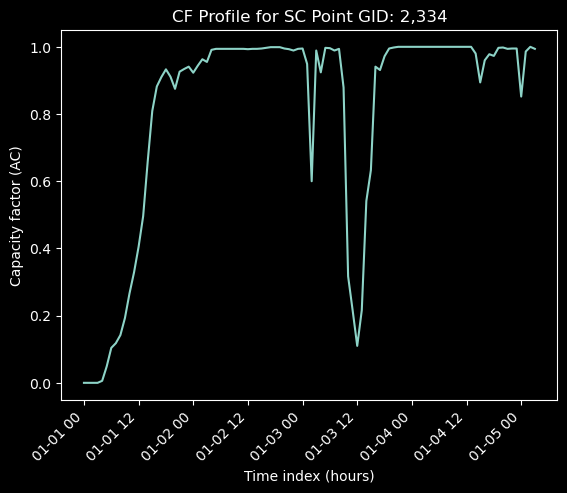

In [36]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {sc_point_gid:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

Reading in multiple profiles at once can be done as well:

In [37]:
sc_point_gids_of_interest = [2334, 34357, 23399, 97844]
points = reference_wind_supply_curve[
    reference_wind_supply_curve["sc_point_gid"].isin(sc_point_gids_of_interest)
]

with h5py.File(WIND_CF_FILEPATH, "r") as fh:
    meta = pd.DataFrame(fh["meta"][:])
    inds = meta[meta["sc_point_gid"].isin(sc_point_gids_of_interest)].index
    profile_scale_factor = fh["rep_profiles_0"].attrs["scale_factor"]
    profiles = fh["rep_profiles_0"][:, inds] / profile_scale_factor
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profiles.shape

(8760, 4)

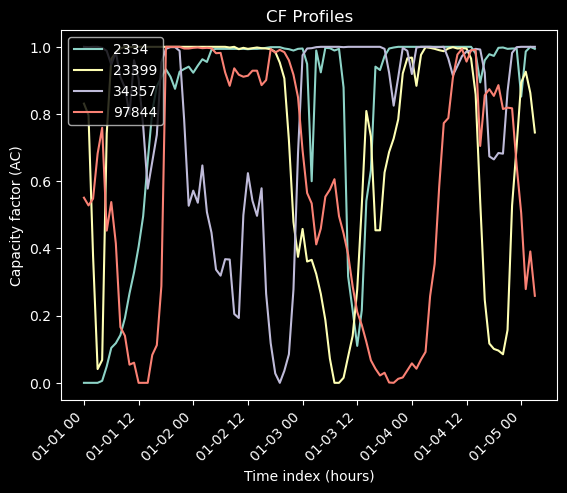

In [38]:
plt.plot(ti[:100], profiles[:100], label=points["sc_point_gid"])
plt.title(f"CF Profiles")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left");

### Extracting info by Lat/Lon

Extracting info for a particular lat/lon is trickier without `rex`, but still doable. You have a few options - the simplest is to do a supply curve sort by a distance to your desired lat/lon (this is what we show below). A more sophisticated but likely more accurate approach is to use a [`cKDtree`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) to look up the closest lat/lon pair to the point in question. This approach is not covered in this notebook.

In [39]:
import numpy as np

my_lat, my_lon = 48.985001,	-119.624001

reference_wind_supply_curve["dist_to_my_point"] = np.hypot(
    reference_wind_supply_curve["latitude"] - my_lat,
    reference_wind_supply_curve["longitude"] - my_lon
)
point = reference_wind_supply_curve.sort_values(
    by="dist_to_my_point"
).iloc[[0]]
point

,area_sq_km,capacity_mw,cnty_fips,country,county,dist_km,elevation,latitude,lcot,longitude,...,state,timezone,total_lcoe,trans_cap_cost_per_mw,reg_mult,turbine_capacity,sc_point_gid,hub_height,windspeed_m_per_s,dist_to_my_point
20,9.169119,174,53047,United States,Okanogan,39.078734,753.7826,48.985,17.410387,-119.624,...,Washington,-8,56.62692,248247.3016,1.057722,6000,2334,115,5.65,0.000001


Once you know the `sc_point_gid`, you can proceed as before:

In [40]:
with h5py.File(WIND_CF_FILEPATH, "r") as fh:
    meta = pd.DataFrame(fh["meta"][:])
    ind = meta[meta["sc_point_gid"] == point["sc_point_gid"].values[0]].index
    profile_scale_factor = fh["rep_profiles_0"].attrs["scale_factor"]
    profile = fh["rep_profiles_0"][:, ind] / profile_scale_factor
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profile.shape

(8760, 1)

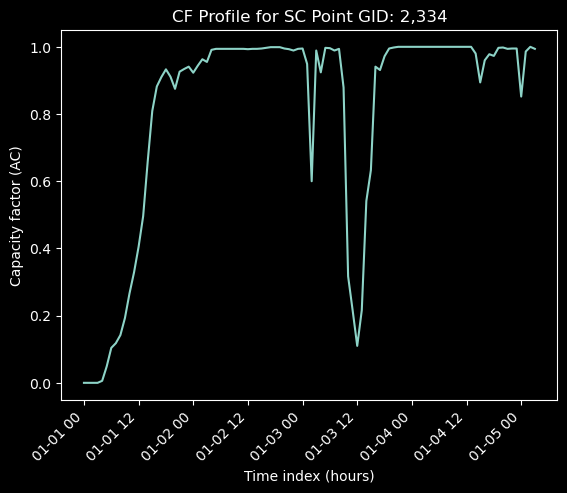

In [41]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {point['sc_point_gid'].iloc[0]:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");